In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


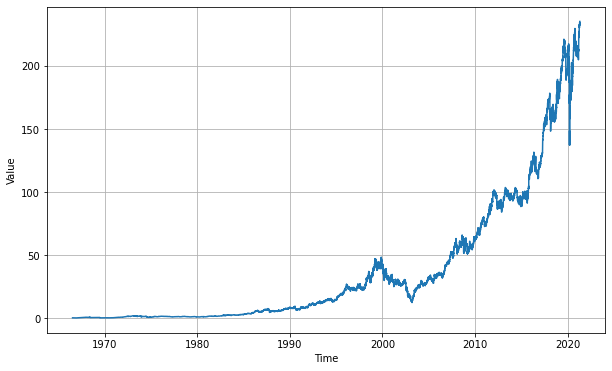

In [63]:
import csv
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def plot_series_all(time, data, title='Asset price', xlabel='year', ylabel='price'):
    plt.plot(time, data)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.show()

def read_data(filepath='../data/MCD-USD.csv'):
    DATE_FORMAT = "%Y-%m-%d"
    time_step = []
    prices = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skip header
        for row in reader:
            if row[4] != 'null':
                # date = datetime.strptime(row[0], DATE_FORMAT)
                # time_step.append(datetime.timestamp(date))
                time_step.append(datetime.strptime(row[0], DATE_FORMAT).date())
                prices.append(float(row[4]))
    # return np.array(time_step, dtype="float32"), np.array(prices, dtype="float32")
    return np.array(time_step), np.array(prices, dtype="float32")

time, series = read_data()
assert not np.any(np.isnan(series))
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

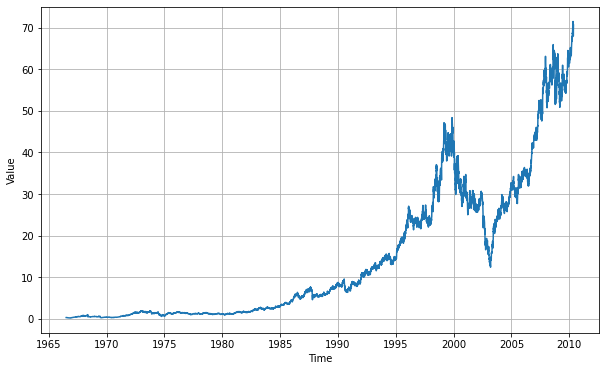

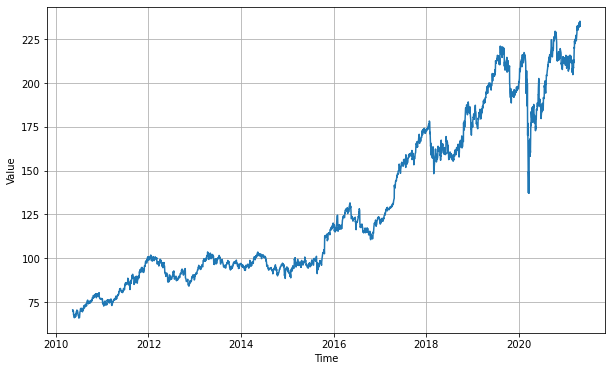

In [64]:
split_time = int(len(time) * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [65]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Normalize the sets:
max_train = np.max(np.abs(x_train), axis=0)
x_train /= max_train

max_valid = np.max(np.abs(x_valid), axis=0)
x_valid /= max_valid

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=500,verbose=2)

Epoch 1/500
345/345 - 1s - loss: 0.4169
Epoch 2/500
345/345 - 1s - loss: 0.3857
Epoch 3/500
345/345 - 1s - loss: 0.3560
Epoch 4/500
345/345 - 1s - loss: 0.3289
Epoch 5/500
345/345 - 1s - loss: 0.3040
Epoch 6/500
345/345 - 1s - loss: 0.2814
Epoch 7/500
345/345 - 1s - loss: 0.2607
Epoch 8/500
345/345 - 1s - loss: 0.2417
Epoch 9/500
345/345 - 1s - loss: 0.2242
Epoch 10/500
345/345 - 1s - loss: 0.2083
Epoch 11/500
345/345 - 1s - loss: 0.1938
Epoch 12/500
345/345 - 1s - loss: 0.1804
Epoch 13/500
345/345 - 1s - loss: 0.1682
Epoch 14/500
345/345 - 1s - loss: 0.1570
Epoch 15/500
345/345 - 1s - loss: 0.1467
Epoch 16/500
345/345 - 1s - loss: 0.1372
Epoch 17/500
345/345 - 1s - loss: 0.1285
Epoch 18/500
345/345 - 1s - loss: 0.1205
Epoch 19/500
345/345 - 1s - loss: 0.1130
Epoch 20/500
345/345 - 1s - loss: 0.1062
Epoch 21/500
345/345 - 1s - loss: 0.0998
Epoch 22/500
345/345 - 1s - loss: 0.0939
Epoch 23/500
345/345 - 1s - loss: 0.0884
Epoch 24/500
345/345 - 1s - loss: 0.0833
Epoch 25/500
345/345 - 1s

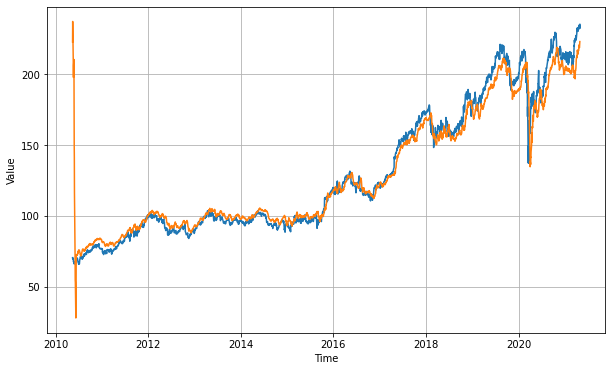

In [66]:
forecast = []

for time in range(len(series) - window_size):
    series_window = series[time:time + window_size]
    # series_window_expanded = np.expand_dims(series_window, axis=0)
    series_window_expanded = series_window[np.newaxis]
    predicted_value = model.predict(series_window_expanded)
    forecast.append(predicted_value)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# Denorm back to prices
results *= max_valid
x_valid *= max_valid

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [67]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

125.38833